In this notebook we take the Illustris-1 simulation volume to find Local Group candidates.

Usually these candidates are found using the dark matter information. 
In this notebook we take a different approach by selecting them based on the baryonic information.

Our candidates are thus pairs selected based on the stellar masses.

1. They are composed by two dark galaxies $G_A$ and $G_B$.
2. $G_A$ and $G_B$ belong to the set of dark matter halos $S_{1}$; $S_{1}$ contains all subhalos with stellar mass content  $2.6\times 10^{10}$ M$_{\odot}<M_s < 1.2\times 10^{11}$ M$_{\odot}$ (http://adsabs.harvard.edu//abs/2013AAS...22125411L, http://arxiv.org/abs/1410.0017)
3. The distance between $H_A$ and $H_B$ is less than 1.3 Mpc.
4. $H_A$ and $H_B$ are mutually its nearest halos in the set $S_{1}$.
5. There are not any subhalos with vmax larger than min(200km/s, Vmax $H_A$, Vmax $H_B$) within $5 \mathrm{Mpc}$ of either $H_A$ or $H_B$.

We now proceed to build such sample.

In [6]:
%pylab inline
import illustris_python as il
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


In [7]:
basePath = '/homecolab/je.forero/data/illustris/illustris-1/'

In [8]:
halos = il.groupcat.loadHalos(basePath,135)
subhalos = il.groupcat.loadSubhalos(basePath,135)

In [334]:
header = il.groupcat.loadHeader(basePath,135)
hubble = 0.7
BoxSize = header['BoxSize']/hubble

In [335]:
print halos.keys()
print subhalos.keys()

[u'Group_M_Crit200', u'Group_R_Mean200', u'GroupMass', u'Group_M_Mean200', u'GroupStarMetallicity', u'GroupVel', u'GroupBHMass', u'GroupMassType', u'Group_R_Crit200', u'GroupFirstSub', u'GroupSFR', u'GroupPos', u'Group_M_TopHat200', u'Group_M_Crit500', u'GroupLenType', u'Group_R_Crit500', u'GroupNsubs', u'Group_R_TopHat200', u'GroupGasMetallicity', 'count', u'GroupBHMdot', u'GroupWindMass', u'GroupLen']
[u'SubhaloPos', u'SubhaloBHMdot', u'SubhaloVmax', u'SubhaloWindMass', u'SubhaloGasMetallicityMaxRad', u'SubhaloVelDisp', u'SubhaloSFR', u'SubhaloStarMetallicityMaxRad', u'SubhaloLen', u'SubhaloSFRinHalfRad', u'SubhaloStellarPhotometrics', u'SubhaloGasMetallicity', u'SubhaloBHMass', u'SubhaloIDMostbound', u'SubhaloMassType', u'SubhaloStellarPhotometricsMassInRad', u'SubhaloHalfmassRad', u'SubhaloParent', u'SubhaloSpin', u'SubhaloStarMetallicityHalfRad', u'SubhaloVel', u'SubhaloLenType', u'SubhaloGasMetallicitySfrWeighted', u'SubhaloGasMetallicityHalfRad', u'SubhaloMassInRad', u'SubhaloGr

In [336]:
#mases are: Gas, DM, unused, tracers, stars+wind particles, black holes
halo_masses = halos['GroupMassType']/hubble
subhalo_masses = subhalos['SubhaloMassType']/hubble
halo_M_crit200 = halos['Group_M_Mean200']/hubble
subhalo_pos = subhalos['SubhaloPos']/hubble
subhalo_stellar_mass = subhalo_masses[:,4]
subhalo_mags = subhalos['SubhaloStellarPhotometrics']
subhalo_vmax = subhalos['SubhaloVmax']
print shape(subhalo_vmax)

(4366546,)


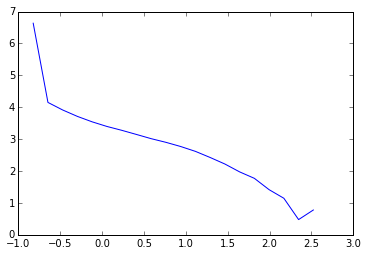

In [337]:
vals, edges = histogram(log10(subhalo_stellar_mass+1E-1), bins=20)
plot(edges[1:], log10(vals))

In [338]:
#selects the indices for two sets:
# 1. MW like
# 2. massive galaxies above 1E11 Msun in stars
# 3. MW like + massive galaxies above 1E11 Msun in stars

index_S1 = where((subhalo_stellar_mass>2.6) & (subhalo_stellar_mass<12.0))
index_S2 = where(subhalo_stellar_mass>12.0)
index_S3 = where(subhalo_stellar_mass>2.6)
n_S1 = size(index_S1)
n_S2 = size(index_S2)
n_S3 = size(index_S3)
print("size set S1: %d halos"%(n_S1))
print("size set S2: %d halos"%(n_S2))
print("size set S3: %d halos"%(n_S3))

size set S1: 2627 halos
size set S2: 696 halos
size set S3: 3323 halos


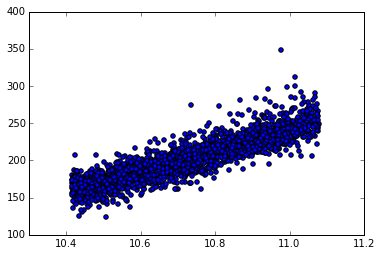

In [339]:
scatter(log10(subhalo_stellar_mass[index_S1])+10, subhalo_vmax[index_S1])

In [340]:
S3_pos = subhalos['SubhaloPos'][index_S3]/hubble
S3_vel = subhalos['SubhaloVel'][index_S3]
S3_vmax = subhalos['SubhaloVmax'][index_S3]
S3_stellar_mass = subhalo_stellar_mass[index_S3]
#https://github.com/forero/IllustrisLG/blob/master/code/LocalGroupSubVolumes.ipynb

In [341]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S3_pad_pos = S3_pos.copy()
S3_pad_vel = S3_vel.copy()
S3_pad_vmax = S3_vmax.copy()
S3_pad_stellar_mass = S3_stellar_mass.copy()
S3_pad_id = arange(n_S3)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S3_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S3_pad_pos = append(S3_pad_pos, new_pos, axis=0)
                S3_pad_vel = append(S3_pad_vel, S3_vel, axis=0)
                S3_pad_vmax = append(S3_pad_vmax, S3_vmax)
                S3_pad_stellar_mass = append(S3_pad_stellar_mass, S3_stellar_mass)
                S3_pad_ID = append(S3_pad_id, arange(n_S3))

In [342]:
nbrs_S3 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S3_pad_pos)
dist_S3, ind_S3 = nbrs_S3.kneighbors(S3_pad_pos)
print S3_pad_pos.shape
print dist_S3.shape

(89721, 3)
(89721, 20)


In [343]:
neighbor_index = ind_S3[:,1]
neighbor_list = ind_S3[:,2:]
print shape(neighbor_list)

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S3):
    l = neighbor_index[neighbor_index[i]]% n_S3
    j = neighbor_index[i] % n_S3
    
    other_j = neighbor_list[i,:] % n_S3
    other_l = neighbor_list[neighbor_index[i],:] % n_S3
    
    if((i==l) & (not (j in halo_A_id)) & (not (j in halo_B_id))): # first check to find mutual neighbors
        
        if((S3_stellar_mass[i]<=12.0) & (S3_stellar_mass[j]<=12.0)): #second check on the masses of the two halos
            
            if(dist_S3[i,1]<(1300.0)): #third check on the distance between the two halos
  
                vmax_i = S3_pad_vmax[i]
                vmax_j = S3_pad_vmax[j]
                vmax_limit = min([vmax_i, vmax_j,200])
                massive_close_to_i = any((dist_S3[i,2:]<(5000.0)) & (S3_vmax[other_j]>=vmax_limit))
                massive_close_to_j = any((dist_S3[j,2:]<(5000.0)) & (S3_vmax[other_l]>=vmax_limit))
                if((not massive_close_to_i) & (not massive_close_to_j)): #third check on isolation from massive halos
                    n_pairs = n_pairs+ 1
                    halo_A_id = append(halo_A_id, int(i))
                    halo_B_id = append(halo_B_id, int(j))
print n_pairs


(89721, 18)
19


In [344]:
print dist_S3[halo_A_id,1]
print neighbor_index[halo_A_id]
print n_S3

[  107.60175593   370.89481273   311.75152027   312.39931164   243.28602601
   702.98911791   837.23504401   588.74239032  1075.79146077   498.0075186
   989.55246713  1153.80888895  1196.16621112   848.85298778   575.80691949
   539.2269212    981.31046758   839.1503194    628.86096251]
[ 1150  1265  1415  1436  1448  1530  1552  1683  2264  1734  3193  3275
  2427 12881  3156  2293  3194  2982  3057]
3323


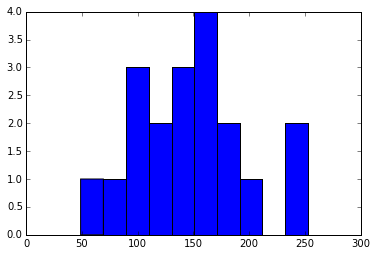

In [345]:
relative_vel = S3_pad_vel[halo_A_id,:] - S3_pad_vel[neighbor_index[halo_A_id], :]
norm_relative_vel = sqrt((relative_vel**2).sum(1))
a = hist(norm_relative_vel)

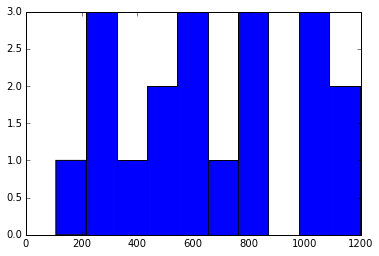

In [346]:
relative_pos = S3_pad_pos[halo_A_id,:] - S3_pad_pos[neighbor_index[halo_A_id], :]
norm_relative_pos = sqrt((relative_pos**2).sum(1))
a = hist(norm_relative_pos)

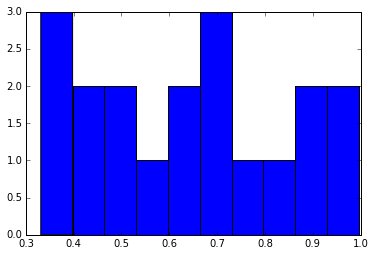

In [347]:
mass_ratio = S3_pad_stellar_mass[halo_A_id]/S3_pad_stellar_mass[neighbor_index[halo_A_id]]
index = where(mass_ratio>1.0)
mass_ratio[index] = 1.0/mass_ratio[index]
a = hist(mass_ratio)

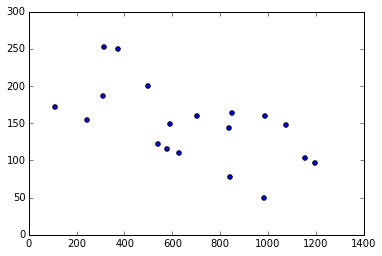

In [348]:
scatter(norm_relative_pos, norm_relative_vel)

#Sub-volume selection

In [349]:
geometric_center = 0.5*(S3_pad_pos[halo_A_id,:] + S3_pad_pos[neighbor_index[halo_A_id],:])

In [350]:
def dump_subvolume(sh, id_list, offset, boxsize, file_id=1, base_filename="test", out_dir="../data/"):
    filename = "%s/%s_%d.dat"%(out_dir, base_filename, file_id)
    out =  open(filename, "w")
    n_points = size(id_list)
    tmp_pos = subhalos['SubhaloPos']
    tmp_mags = subhalos['SubhaloStellarPhotometrics']
    tmp_vel = subhalos['SubhaloVel']
    tmp_vmax = subhalos['SubhaloVmax']
    out.write("#subID\t x\t y\t z\t vx\t yv\t yz\t vmax\t B_MAG\n")
    out.write("#subID\t kpc/h\t kpc/h\t kpc/h\t km/s\t km/s\t km/s\t km/s\t mags\n")
    for i in range(n_points):
        ii = id_list[i]
        out.write("%d %f %f %f %f %f %f %f %e\n"%(ii, tmp_pos[ii,0], tmp_pos[ii,1], tmp_pos[ii,2], 
                                       tmp_vel[ii,0], tmp_vel[ii,1], tmp_vel[ii,2],
                                       tmp_vmax[ii], subhalo_mags[ii,1]))

In [351]:
n_subs = size(subhalo_vmax)
print n_subs
for i in range(n_pairs):
    center = geometric_center[i,:]%BoxSize
   
    delta = subhalo_pos.copy()
    delta[:,0] = (delta[:,0] - center[0] + BoxSize/2.0)
    delta[:,1] = (delta[:,1] - center[1] + BoxSize/2.0)
    delta[:,2] = (delta[:,2] - center[2] + BoxSize/2.0)
    delta = delta%BoxSize
    
    norm_delta = sqrt(((delta - BoxSize/2.0)**2).sum(1))
    inside = where(norm_delta<3000.0)
    inside = inside[0]
    dump_subvolume(subhalos, inside, (center-BoxSize/2.0)*hubble, BoxSize*hubble, file_id=i, base_filename="Illustris_group", out_dir="../data/mstar_selected/")
    print size(inside)

4366546
1210
1200
1223
1186
1297
682
939
755
933
1024
837
701
790
1162
556
487
900
517
544


In [352]:
for i in arange(19):
    data = loadtxt("../data/mstar_selected/Illustris_group_%d.dat"%(i))
    vmax = data[:,7]
    vmax.sort()
    print i, vmax[-3:]

0 [ 149.190567  161.597122  299.602234]
1 [ 141.934021  186.93631   218.016418]
2 [ 137.905945  195.877991  248.250809]
3 [ 117.541985  247.44577   260.069916]
4 [ 167.486877  204.488495  232.046341]
5 [  99.792709  212.407562  238.893463]
6 [ 145.491425  207.440659  235.117157]
7 [ 122.433281  212.02388   220.957367]
8 [ 123.140915  195.777115  213.110107]
9 [ 138.121384  177.108322  206.920273]
10 [ 150.696472  190.419693  213.00856 ]
11 [  91.313087  176.170227  223.329086]
12 [ 110.93264   230.900787  240.52977 ]
13 [ 149.709885  177.749603  209.792328]
14 [ 134.567154  179.053665  242.480118]
15 [  70.238716  167.142242  187.629517]
16 [ 116.819229  185.877182  194.799484]
17 [ 119.409401  172.569702  183.159561]
18 [ 120.026787  164.992905  171.813354]


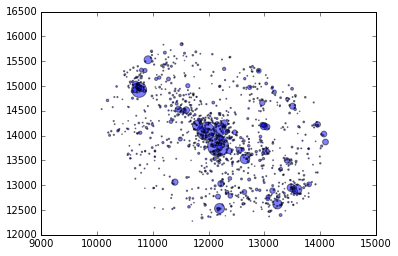

In [369]:
data = loadtxt("../data/mstar_selected/Illustris_group_13.dat")
scatter(data[:,3], data[:,1], s=data[:,7]**2/100, alpha=0.5)